# PhenoGraph Pipeline
## 4/4 Survival Analysis with Signatures Gained from Single Cell Data

This part transfer the problem to existing problems. We use the signature gained through linear regression between single cell features and GEO array data set to perform survival analysis.

Assuming you have get the signatures of %IFPC %SDPC and published signatures(Eppert et al., 2011).

In [1]:
import numpy as np
import pandas as pd 
import lifelines as ll
from itertools import *
import networkx as nx
%matplotlib inline

## Mapping Arrays Probes to Genes the Previous Way

We used gene expression and survival data for 242 cytogenetically normal adult AML patients from two independent cohorts (Metzeler et al., 2008), consisting of arrays from two different Affymetrix platforms (U133A, U133 Plus 2.0).

- U133A 
    - GPL96 
    - 163
- U133 Plus 2.0
    - GPL570 
    - 79

In [2]:
def preprocess(probes):
    assert type(probes) != "pandas.core.frame.DataFrame"
    print(probes.shape)
    probes = np.log2(probes.loc[:,:])
    probes = probes.T
#     probes = probes/probes.quantile(0.75)
#   exclude by standard deviation
    excluded_probes_1 = []
#     for c in probes.columns:
#         if (probes[c].std()) <= 0.25 :
#             excluded_probes_1.append(c)
#     print("{} were removed for low std (defined as being below 0.25)".format(len(excluded_probes_1)))
    
#     # exclude by intensities
    excluded_probes_2 = []
#     for c in probes.columns:
#         if sum(probes[c]<7) >= 3/4 * probes.shape[0]:
#             excluded_probes_2.append(c)
#     print("{} were removed for low intensity (defined as being below 7 on log2 scale in at least 12 of the 16 arrays)".format(len(excluded_probes_2)))
    
#     probes = probes.T
    probes = probes/probes.quantile(0.75)
    probes = probes.iloc[:,np.logical_not(probes.columns.isin(excluded_probes_2+excluded_probes_1))]    
        
    return probes

def create_mappings(probe_e,gene_knowledge):
    # average probes targeting for a same gene
    tagret_genes = []
#     print(gene_knowledge.columns)
#     print(probe_e.index)
    
    genes_to_probes={}
    assert gene_knowledge.shape[0] == probe_e.shape[1]
    gene_knowledge = gene_knowledge.ix[probe_e.columns.values]
    
    for c in probe_e.columns.values:
        tagret_genes.append(gene_knowledge.loc[c,['Gene Symbol']].values[0])
    
    tagret_genes = np.array(tagret_genes)
    print(len(tagret_genes))
    tagret_genes_split = []

    for i,t in enumerate(tagret_genes):
        if type(t[0]) == str:
            tagret_genes_split.append(t.split("///"))    
    print(len(tagret_genes_split))
    #  creat a mapping dictionary

    for i,gs in enumerate(tagret_genes_split):
        for g in gs:
            genes_to_probes[str.strip(g)] = []

    for i,gs in enumerate(tagret_genes_split):
        for g in gs:
            genes_to_probes[str.strip(g)].append(gene_knowledge.index[i])

    del genes_to_probes["nan"]
    
    return genes_to_probes

# def mapping_to_genes(probe_e,genes_to_probes):
#     count = 0 
#     exclueded_genes = []
#     gene_expression = pd.DataFrame([],index=probe_e.index)
#     for gene in genes_to_probes:
#         # if there are more than 1 probe target this gene
#         if len(genes_to_probes[gene]) > 1: 

#             # finding the correlation matrix of probes
#             r = np.corrcoef(probe_e[genes_to_probes[gene]],rowvar=0)
#     #         for i in range(r.shape[0]):
#     #             for j in range(r.shape[1]):
#     #                 if i==j:
#     #                     r[i,j] = 1
#             s = r > 0.75

#             if np.sum(s.flatten()) == 0:
#                 exclueded_genes.append(gene)
#     #           no edge
#                 continue
        
#             G = nx.from_numpy_matrix(s)
#             generator = nx.find_cliques(G)

#             memberlist = [c for c in generator]
#     #        if none in this subset is correlated to each other, skip


#     #       max clique menber indexes
#             ixx = np.argmax([len(l) for l in memberlist])
#             subset = memberlist[ixx]

#             if len(subset) <= 1:
#     #            all cliques has itself as the only member
#     #            gene_expression[gene] = probe_e[genes_to_probes[gene][0]]
#                 exclueded_genes.append(gene)
#                 continue
#             else:
#                 t = np.array(genes_to_probes[gene])
#                 t = t[subset]
#                 gene_expression[gene] = probe_e[t].mean(axis=1)
#                 count = count + 1

#         else:
#             gene_expression[gene] = probe_e[genes_to_probes[gene]]
#             count = count + 1
#     print("Probe sets targeting the same gene whose measurementswere well correlated (r > .75) were averaged to produce consensus expression values for {} unique genes.".format(count) )
#     print("{} Genes were excluded for they are targeted by several uncorrelated probes".format(len(exclueded_genes)) )
#     return gene_expression

def mapping_to_genes(probe_e,genes_to_probes):
    count = 0 
    exclueded_genes = []
    gene_expression = pd.DataFrame([],index=probe_e.index)
    for gene in genes_to_probes:
        # if there are more than 1 probe target this gene
        if len(genes_to_probes[gene]) > 1: 

            # finding the correlation matrix of probes
#             r = np.corrcoef(probe_e[genes_to_probes[gene]],rowvar=0)
    #         for i in range(r.shape[0]):
    #             for j in range(r.shape[1]):
    #                 if i==j:
    #                     r[i,j] = 1
#             s = r > 0.75

#             if np.sum(s.flatten()) == 0:
#                 exclueded_genes.append(gene)
    #           no edge
#                 continue
        
#             G = nx.from_numpy_matrix(s)
#             generator = nx.find_cliques(G)

#             memberlist = [c for c in generator]
    #        if none in this subset is correlated to each other, skip


    #       max clique menber indexes
#             ixx = np.argmax([len(l) for l in memberlist])
#             subset = memberlist[ixx]

#             if len(subset) <= 1:
    #            all cliques has itself as the only member
    #            gene_expression[gene] = probe_e[genes_to_probes[gene][0]]
#                 exclueded_genes.append(gene)
#                 continue
#             else:
                t = np.array(genes_to_probes[gene])
#                 t = t[subset]
                gene_expression[gene] = probe_e[t].mean(axis=1)
                count = count + 1

        else:
            gene_expression[gene] = probe_e[genes_to_probes[gene]]
            count = count + 1
    print("Probe sets targeting the same gene whose measurementswere well correlated (r > .75) were averaged to produce consensus expression values for {} unique genes.".format(count) )
    print("{} Genes were excluded for they are targeted by several uncorrelated probes".format(len(exclueded_genes)) )
    return gene_expression

In [3]:
GPL96_samples = pd.read_csv("GEO/GSE12417-GPL96_series_matrix.csv",index_col=0,header=69)
GPL96_knowledge = pd.read_csv("GEO/GPL96-57554.csv",index_col=0)

GPL570_samples = pd.read_csv("GEO/GSE12417-GPL570_series_matrix.csv",index_col=0,header=68)
GPL570_knowledge = pd.read_csv("GEO/GPL570-55999.csv",header=16,index_col=0)
# filter null values
# GPL96_samples = GPL96_samples.drop(GPL96_samples[pd.isnull(GPL96_samples).sum(axis=1) > 0].index)
# GPL570_samples = GPL570_samples.drop(GPL96_samples[pd.isnull(GPL96_samples).sum(axis=1) > 0].index)
GPL96_samples = GPL96_samples.drop("!series_matrix_table_end")
GPL570_samples = GPL570_samples.drop("!series_matrix_table_end")
sample_list = [[GPL96_samples,GPL96_knowledge],[GPL570_samples,GPL570_knowledge]]

/Users/xiaolibird/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
# gene_e = []
# for i,s in enumerate(sample_list):
#     print(i+1)
#     s[0] = preprocess(s[0])
#     s.append(mapping_to_genes(s[0],
#                               create_mappings(s[0],
#                                               s[1])))
GPL96_samples = preprocess(GPL96_samples)
dic96 = create_mappings(GPL96_samples,GPL96_knowledge)
gene96 = mapping_to_genes(GPL96_samples,dic96)

(22283, 163)
22283
22283
Probe sets targeting the same gene whose measurementswere well correlated (r > .75) were averaged to produce consensus expression values for 14207 unique genes.
0 Genes were excluded for they are targeted by several uncorrelated probes


In [5]:
GPL570_samples = preprocess(GPL570_samples)
dic570 = create_mappings(GPL570_samples,GPL570_knowledge)
gene570 = mapping_to_genes(GPL570_samples,dic570)

(54675, 79)
54675
54675
Probe sets targeting the same gene whose measurementswere well correlated (r > .75) were averaged to produce consensus expression values for 24441 unique genes.
0 Genes were excluded for they are targeted by several uncorrelated probes


In [6]:
ref_sig = pd.read_csv("signature.csv")

In [7]:
ref_sig

,IFPC,SDPC,(IFPC and SDPC)
0,PROM1,CD34,B4GALT6
1,RRAGD,GIT2,CD69
2,GPHN,ITM2C,EMP1
3,CPA3,PMAIP1,GNG7
4,FOSB,PTGER4,IL1RAP
5,ATF3,EHD3,JUP
6,CD96,MIR4448,KIT
7,IL8,MRC1,LOC282997
8,ATP1B1,HGF,LTBP3
9,SIK1,CD200,PDGFC


In [24]:
selected_signature = "IFPC"
# selected_signature = "SDPC"
gene_sig_96 = gene96[ref_sig[selected_signature].ix[ref_sig[selected_signature].isin(gene96.columns)]]

gene_sig_570 = gene570[ref_sig[selected_signature].ix[ref_sig[selected_signature].isin(gene570.columns)]]

Each gene was centered such that its mean expression across arrays was 0. For each patient, the frequency of a cell type (%IFPC or %SDPC) was estimated as the **mean expression intensity of the associated gene signature** because single-cell data was not available. For **Kaplan-Meier analysis** (Fig. 7B and Fig. S6B), patients were **stratified into two groups based on the median expression** value of the signature of interest.

In [25]:
# samples_for_km = pd.concat([gene_sig_96,gene_sig_570],axis=0)
samples_for_km = pd.concat([gene_sig_96],axis=0)
samples_for_km = samples_for_km - samples_for_km.mean()
samples_for_km["mean"] = samples_for_km.mean(axis=1)
samples_for_km["group"] = samples_for_km["mean"] >= samples_for_km["mean"].median()

In [26]:
s96 = pd.read_csv("GEO/Survival96.csv",index_col=0)

dict_array = []
for info in s96.ix[0]:
    dict_temp = {}
    for i,t in enumerate(info.split(";")):
        if i == 0 :
            dict_temp["type"] = t
        elif i == 3:
            dict_temp["status"] = int(t.split(" ")[-1])
        else:
            dict_temp[str.strip(t.split("=")[0])] = str.strip(info.split(';')[i].split('=')[1]).split(' ')[0]
    
    dict_array.append(dict_temp)
s96_df = pd.DataFrame(dict_array,index = s96.columns)

In [27]:
s570 = pd.read_csv("GEO/Survival570.csv",index_col=0)

dict_array = []
for info in s570.ix[0]:
    dict_temp = {}
    for i,t in enumerate(info.split(";")):
        if i == 0 :
            dict_temp["type"] = t
        elif i == 3:
            dict_temp["status"] = int(t.split(" ")[-1])
        else:
            dict_temp[str.strip(t.split("=")[0])] = int(str.strip(info.split(';')[i].split('=')[1]).split(' ')[0])
    
    dict_array.append(dict_temp)
s570_df = pd.DataFrame(dict_array,index = s570.columns)

In [28]:
# survival_df = pd.concat([s96_df,s570_df],axis=0)
survival_df = pd.concat([s96_df],axis=0)

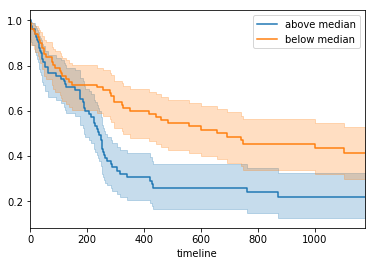

In [29]:
T = survival_df['OS'].astype("int")
E = survival_df['status'].astype("int")

from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()
# kmf.fit(T, event_observed=E) # more succiently, kmf.fit(T,E)


# kmf.plot()

groups = samples_for_km['group']
ix = (groups == True)

kmf.fit(T[ix], E[ix], label='above median')
kmf.survival_function_
kmf.median_
ax = kmf.plot()

kmf.fit(T[~ix], E[~ix], label='below median')
kmf.survival_function_
kmf.median_
kmf.plot(ax=ax)

In [30]:
from lifelines.statistics import logrank_test

results = logrank_test(T[ix], T[~ix], E[ix], E[~ix], alpha=.99 )

results.print_summary()

Results
   df: 1
   alpha: 0.99
   t 0: -1
   null distribution: chi squared
   test: logrank

   __ p-value ___|__ test statistic __|____ test result ____|__ is significant __
         0.00172 |              9.831 |      Reject Null    |        True       


Results
   df: 1
   alpha: 0.99
   t 0: -1
   null distribution: chi squared
   test: logrank

   __ p-value ___|__ test statistic __|____ test result ____|__ is significant __
         0.03137 |              4.633 |  Cannot Reject Null |       False       


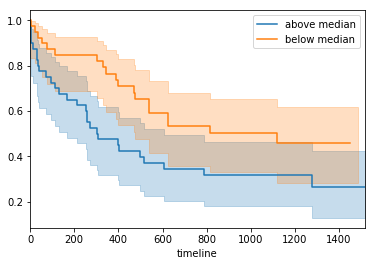

In [37]:
samples_for_km = gene_sig_570
samples_for_km = samples_for_km - samples_for_km.mean()
samples_for_km["mean"] = samples_for_km.mean(axis=1)
samples_for_km["group"] = samples_for_km["mean"] >= samples_for_km["mean"].median()

survival_df = s570_df

T = survival_df['OS'].astype("int")
E = survival_df['status'].astype("int")

kmf = KaplanMeierFitter()

groups = samples_for_km['group'].values
ix = (groups == True)

kmf.fit(T[ix], E[ix], label='above median')
kmf.survival_function_
kmf.median_
ax = kmf.plot()

kmf.fit(T[~ix], E[~ix], label='below median')
kmf.survival_function_
kmf.median_
kmf.plot(ax=ax)

results = logrank_test(T[ix], T[~ix], E[ix], E[~ix], alpha=.99 )

results.print_summary()

For survival analysis, the **overall survival and right-censor fields of the metadata** were used to estimate the clinical significance of each gene signature.

For comparison between the **IFPC signature** and **three published gene signatures** (Eppert et al., 2011), signature scores were calculated as the **mean signature expression**, as described above. We noted that all three Eppert signatures contained one or two genes in common with the IFPC signature. In all cases, we removed these genes from the IFPC signature and allowed them to be retained by the Eppert signature.

In [43]:
# regression_dataset = (s570_df[["OS","status"]])
# regression_dataset["mean"] = gene_sig_570.mean(axis=1).values
# regression_dataset["mean"] = gene_sig_570.mean(axis=1).values
regression_dataset = gene_sig_570.join(s570_df[["OS","status"]].astype('int'))

from lifelines import CoxPHFitter

# Using Cox Proportional Hazards model
cf = CoxPHFitter()
cf.fit(regression_dataset, 'OS', event_col='status')
cf.print_summary()

print(cf.hazards_)

n=79, number of events=47

               coef  exp(coef)  se(coef)          z         p  lower 0.95  upper 0.95     
PROM1     2.663e+00  1.434e+01 7.755e-01  3.434e+00 5.948e-04   1.143e+00   4.183e+00  ***
RRAGD     2.016e-01  1.223e+00 6.856e-01  2.940e-01 7.688e-01  -1.142e+00   1.546e+00     
GPHN     -6.391e-01  5.278e-01 4.700e-01 -1.360e+00 1.739e-01  -1.561e+00   2.823e-01     
CPA3      2.265e+00  9.628e+00 8.013e-01  2.826e+00 4.708e-03   6.939e-01   3.835e+00   **
FOSB      1.915e+00  6.785e+00 8.063e-01  2.374e+00 1.757e-02   3.339e-01   3.495e+00    *
ATF3      7.706e-01  2.161e+00 6.539e-01  1.178e+00 2.386e-01  -5.113e-01   2.053e+00     
CD96      4.416e-02  1.045e+00 7.719e-01  5.721e-02 9.544e-01  -1.469e+00   1.557e+00     
ATP1B1   -4.724e-01  6.235e-01 1.002e+00 -4.716e-01 6.372e-01  -2.436e+00   1.491e+00     
SIK1     -1.571e+00  2.079e-01 8.207e-01 -1.914e+00 5.565e-02  -3.180e+00   3.824e-02    .
TPBG      1.262e+00  3.532e+00 6.483e-01  1.947e+00 5.159e-02  

In [42]:
regression_dataset = gene_sig_96.join(s96_df[["OS","status"]].astype('int'))

from lifelines import CoxPHFitter

# Using Cox Proportional Hazards model
cf = CoxPHFitter()
cf.fit(regression_dataset, 'OS', event_col='status')
cf.print_summary()

n=163, number of events=103

               coef  exp(coef)  se(coef)          z         p  lower 0.95  upper 0.95     
PROM1    -2.473e-02  9.756e-01 1.905e-01 -1.298e-01 8.967e-01  -3.981e-01   3.487e-01     
RRAGD     3.407e-01  1.406e+00 2.408e-01  1.415e+00 1.571e-01  -1.314e-01   8.128e-01     
GPHN      3.683e-01  1.445e+00 1.874e-01  1.965e+00 4.941e-02   8.781e-04   7.357e-01    *
CPA3     -3.059e-01  7.365e-01 2.644e-01 -1.157e+00 2.473e-01  -8.241e-01   2.124e-01     
FOSB     -1.094e-01  8.963e-01 2.597e-01 -4.214e-01 6.734e-01  -6.185e-01   3.996e-01     
ATF3      3.009e-01  1.351e+00 2.771e-01  1.086e+00 2.775e-01  -2.423e-01   8.441e-01     
CD96      4.051e-01  1.500e+00 2.297e-01  1.764e+00 7.781e-02  -4.523e-02   8.555e-01    .
ATP1B1   -3.295e-01  7.193e-01 2.557e-01 -1.289e+00 1.975e-01  -8.308e-01   1.717e-01     
SIK1     -1.499e-01  8.608e-01 2.388e-01 -6.280e-01 5.300e-01  -6.180e-01   3.181e-01     
TPBG      1.092e-01  1.115e+00 1.545e-01  7.068e-01 4.797e-01

/Users/xiaolibird/anaconda3/lib/python3.5/site-packages/lifelines-0.9.4-py3.5.egg/lifelines/fitters/coxph_fitter.py:333: RuntimeWarning: Column(s) ['LENEP', 'KCNJ8', 'CLDN6'] have very low variance. This may harm convergence. Try dropping this redundant column before fitting if convergence fails.
  warnings.warn(warning_text, RuntimeWarning)


In [49]:
cf.hazards_

,PROM1,RRAGD,GPHN,CPA3,FOSB,ATF3,CD96,ATP1B1,SIK1,TPBG,...,GLS,DUSP10,IGFBP2,ADA,ITPR2,PLXNC1,SOCS2,ANKRD28,DNMT3B,SMAD1
coef,2.663,0.201563,-0.639105,2.264684,1.914657,0.770612,0.044159,-0.472381,-1.570637,1.261899,...,0.08694,-2.197003,-0.600878,-0.135782,0.416673,-0.951855,1.450705,-0.248755,0.190051,-1.938573
